In [5]:
import os, sys

# 1. Compute the src/ directory (one level up from notebooks/)
notebooks_dir = os.getcwd()                            # e.g. …/graphworld/src/notebooks
src_dir       = os.path.abspath(os.path.join(notebooks_dir, os.pardir))
# 2. Prepend it to Python’s module search path
if src_dir not in sys.path:
    sys.path.insert(0, src_dir)

# 3. Now you can import as expected
from graph_world.models.basic_gnn import HGCN
print("✅ Imported HGCN from", HGCN)

✅ Imported HGCN from <class 'graph_world.models.basic_gnn.HGCN'>


In [6]:
import time
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_undirected

from graph_world.models.basic_gnn import GCN, HGCN

# 1) Load Cora
dataset = Planetoid(root='.', name='Cora')
data = dataset[0]
data.edge_index = to_undirected(data.edge_index)
device = torch.device("cpu") 
data = data.to(device)

def train_model(model, data, epochs=200, lr=0.01, weight_decay=5e-4):
    opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    model.train()
    for _ in range(epochs):
        opt.zero_grad()
        out = model(data.x, data.edge_index)
        loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
        loss.backward()
        opt.step()
    return model

def test_model(model, data):
    model.eval()
    logits = model(data.x, data.edge_index)
    pred = logits.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        accs.append((pred[mask] == data.y[mask]).float().mean().item())
    return accs  # train, val, test

def param_count(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# 2) Instantiate & run GCN
gcn = GCN(in_channels=dataset.num_node_features,
          hidden_channels=16,
          num_layers=2,
          out_channels=dataset.num_classes,
          dropout=0.5).to(device)

t0 = time.time()
gcn = train_model(gcn, data)
gcn_time = time.time() - t0
gcn_accs = test_model(gcn, data)

print(f"GCN params: {param_count(gcn):,}  train/val/test = {gcn_accs}  time = {gcn_time:.2f}s")

# 3) Instantiate & run HGCN
hgcn = HGCN(in_channels=dataset.num_node_features,
            hidden_channels=16,
            num_layers=2,
            out_channels=dataset.num_classes,
            c=None,            # learnable curvatures
            manifold='Hyperboloid',
            dropout=0.5,
            bias=True,
            act_name='relu').to(device)

t0 = time.time()
hgcn = train_model(hgcn, data)
hgcn_time = time.time() - t0
hgcn_accs = test_model(hgcn, data)

print(f"HGCN hyperboloid params: {param_count(hgcn):,}  train/val/test = {hgcn_accs}  time = {hgcn_time:.2f}s")


GCN(in_channels = 1433, hidden_channels = 16, out_channels = 7, num_layers=2) 
GCN params: 23,335  train/val/test = [1.0, 0.7459999918937683, 0.7789999842643738]  time = 1.08s
HGCN(in=1433, hid=16, layers=2, out=7, manifold=Hyperboloid, c = None)
HGCN hyperboloid params: 23,354  train/val/test = [1.0, 0.7239999771118164, 0.7459999918937683]  time = 13.57s


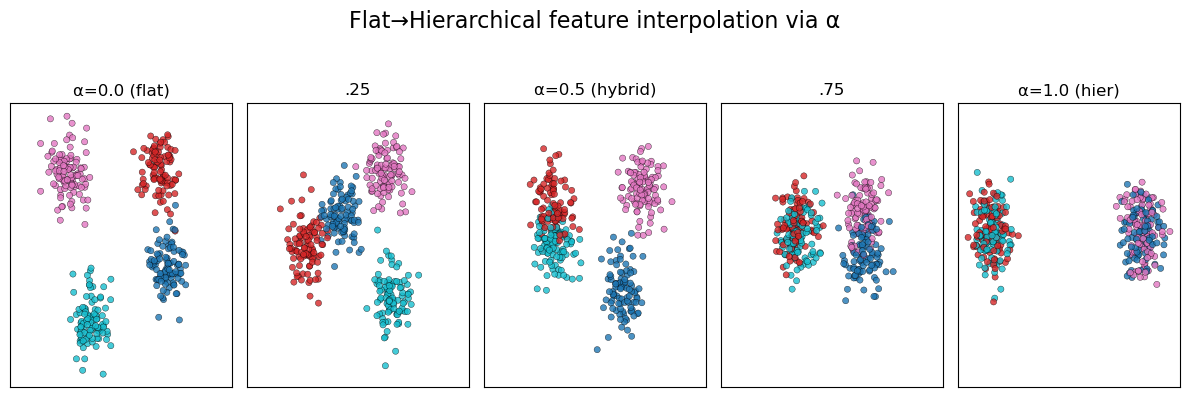

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from graph_world.generators.sbm_simulator import _SimulateHierarchicalFeatures


# === Choose number of nodes & classes ===
N = 400
K = 4
labels = np.random.choice(K, size=N)  # random assignment to 4 classes
D = 16                                # we will generate 16‐dim features

base_d = 2.0    # choose a separation scale
sigma_noise = 1.0

# Values of alpha to test
alphas = [0.0, 0.25, .5, .75, 1.0]
titles = ["α=0.0 (flat)", ".25", "α=0.5 (hybrid)", ".75", "α=1.0 (hier)"]

# Build figure
fig, axes = plt.subplots(1, len(alphas), figsize=(12, 4), sharex=True, sharey=True)

for ax, α, title in zip(axes, alphas, titles):
    X = _SimulateHierarchicalFeatures(
        labels=labels,
        feature_dim=D,
        alpha=α,
        base_distance=base_d,
        noise_variance=sigma_noise,
        # force exactly 2 super‐groups so you see the hierarchy clearly
        num_supergroups=2
    )
    # Reduce to 2D via PCA for plotting
    X2 = PCA(n_components=2).fit_transform(X)

    scatter = ax.scatter(
        X2[:, 0], X2[:, 1],
        c=labels, cmap="tab10", s=20, alpha=0.8,
        edgecolor="k", linewidth=0.3
    )
    ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])

plt.suptitle("Flat→Hierarchical feature interpolation via α", fontsize=16)
plt.tight_layout(rect=[0,0,1,0.93])
plt.show()


Generating a sample SBM graph...
Graph generated successfully.
Training the model...
Epoch: 000, Loss: 1.4269
Epoch: 020, Loss: 1.1490
Epoch: 040, Loss: 0.8327
Epoch: 060, Loss: 0.6095
Epoch: 080, Loss: 0.4607
Epoch: 100, Loss: 0.3488
Epoch: 120, Loss: 0.2772
Epoch: 140, Loss: 0.2377
Epoch: 160, Loss: 0.2154
Epoch: 180, Loss: 0.2016
Epoch: 200, Loss: 0.1922

Final Model Accuracy: 0.9500
Generating visualizations...


/Users/daniel/miniconda3/envs/graphworld/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


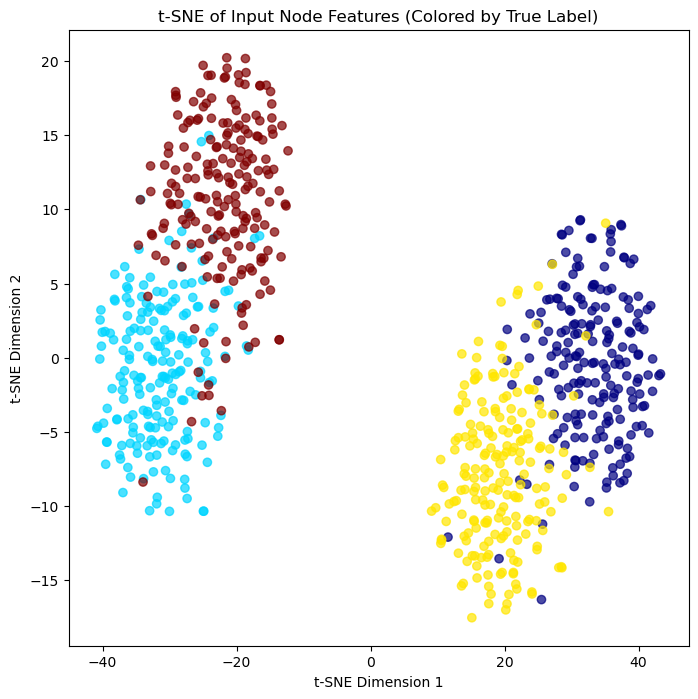

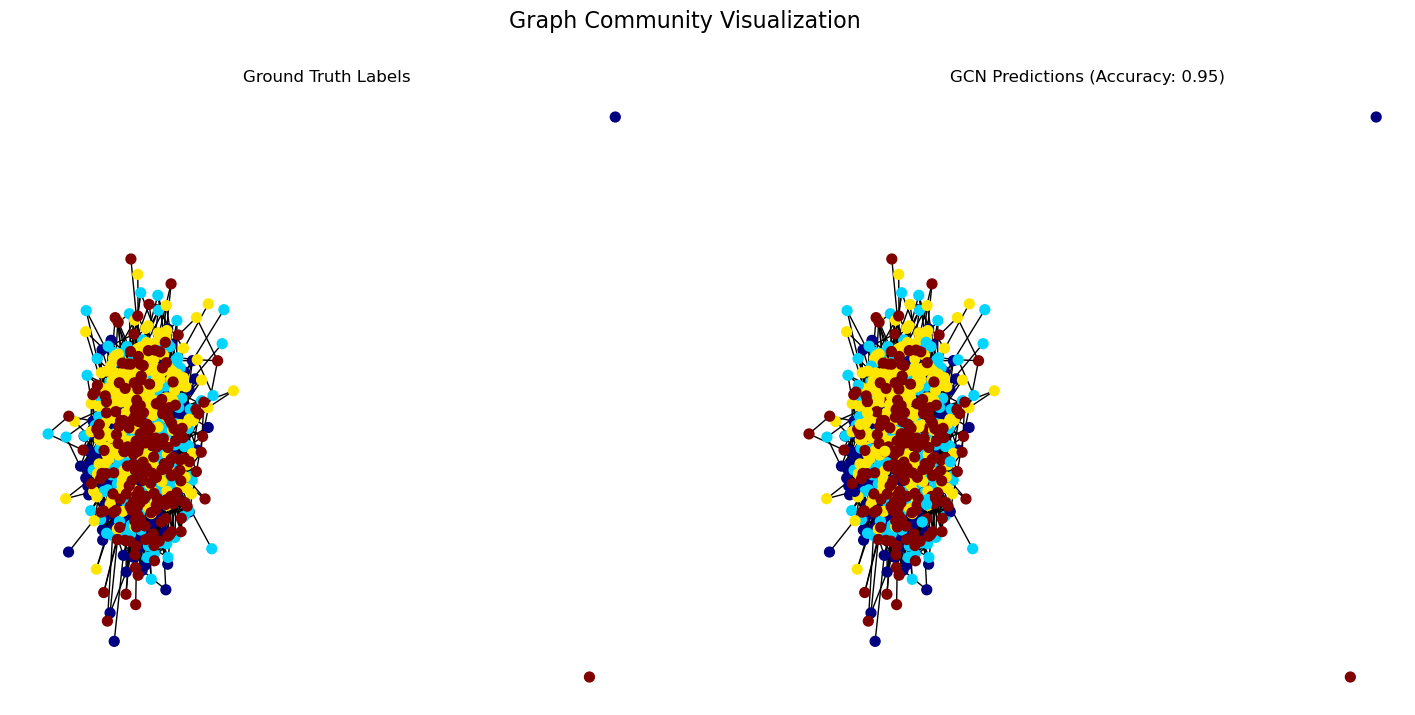

In [16]:
import torch
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from torch_geometric.utils import to_networkx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import networkx as nx

# Make sure to import your SBM simulator functions
from graph_world.generators.sbm_simulator import (
    GenerateStochasticBlockModelWithHierarchicalFeatures,
    MatchType,
    MakePi,
    MakePropMat
)

# --- 1. Generate a "Toy" Graph ---
# We'll use fixed parameters to create an obvious, learnable graph.
print("Generating a sample SBM graph...")

# Parameters for a clear visual example
params = {
    'num_vertices': 800,
    'num_clusters': 4,
    'feature_dim': 16,
    'p_to_q_ratio': 7.0,  # High ratio for distinct communities
    'feature_center_distance': 2.5, # High distance for distinct feature clusters
    'feature_cluster_variance': 1.0, # Low variance for tight feature clusters
    'alpha': .75 # Test the hierarchical interpolation
}

# Generate the graph data
pi = MakePi(params['num_clusters'], community_size_slope=0.0)
prop_mat = MakePropMat(params['num_clusters'], params['p_to_q_ratio'])
sbm_data = GenerateStochasticBlockModelWithHierarchicalFeatures(
    num_vertices=params['num_vertices'],
    num_edges=params['num_vertices'] * 10,
    pi=pi,
    alpha = params['alpha'],
    prop_mat=prop_mat,
    num_feature_groups=params['num_clusters'],
    feature_group_match_type=MatchType.GROUPED,
    feature_dim=params['feature_dim'],
    feature_center_distance= params['feature_center_distance'],
    feature_cluster_variance=params['feature_cluster_variance'],
)

# Convert to PyTorch Geometric Data object
edge_index = torch.tensor(list(sbm_data.graph.get_edges().T), dtype=torch.long)
x = torch.tensor(sbm_data.node_features, dtype=torch.float)
y = torch.tensor(sbm_data.graph_memberships, dtype=torch.long)
data = Data(x=x, edge_index=edge_index, y=y)

print("Graph generated successfully.")

# --- 2. Define and Train a Simple GCN Model ---
class SimpleGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Instantiate the model and optimizer
model = SimpleGCN(
    in_channels=data.num_node_features,
    hidden_channels=16,
    out_channels=params['num_clusters']
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

# Training loop
print("Training the model...")
model.train()
for epoch in range(201):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out, data.y)
    loss.backward()
    optimizer.step()
    if epoch % 20 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')

# Get final predictions
model.eval()
final_out = model(data.x, data.edge_index)
preds = final_out.argmax(dim=1)
accuracy = torch.sum(preds == data.y).item() / len(data.y)
print(f"\nFinal Model Accuracy: {accuracy:.4f}")

# --- 3. Create Visualizations ---
print("Generating visualizations...")

# Visualization A: t-SNE of Input Features
tsne = TSNE(n_components=2, perplexity=30, learning_rate='auto', init='pca', n_iter=1000)
features_2d = tsne.fit_transform(data.x.numpy())

plt.figure(figsize=(8, 8))
plt.scatter(features_2d[:, 0], features_2d[:, 1], c=data.y.numpy(), cmap='jet', alpha=0.7)
plt.title('t-SNE of Input Node Features (Colored by True Label)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.show()

# Visualization B: Graph Layout with True vs. Predicted Labels
# Convert PyG data to NetworkX graph for plotting
g_nx = to_networkx(data, to_undirected=True)
pos = nx.spring_layout(g_nx, seed=42) # Force-directed layout

fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Plot 1: Ground Truth
axes[0].set_title('Ground Truth Labels')
nx.draw(g_nx, pos, with_labels=False, node_size=50,
        node_color=data.y.numpy(), cmap='jet', ax=axes[0])

# Plot 2: Model Predictions
axes[1].set_title(f'GCN Predictions (Accuracy: {accuracy:.2f})')
nx.draw(g_nx, pos, with_labels=False, node_size=50,
        node_color=preds.numpy(), cmap='jet', ax=axes[1])

plt.suptitle('Graph Community Visualization', fontsize=16)
plt.show()